In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:

# Charger les jeux de données
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# Prétraitement des données
train_df = train_df.drop(columns=['Surname', 'CustomerId'])
test_df = test_df.drop(columns=['Surname', 'CustomerId'])

In [10]:
# Display the first few rows of train and test datasets
display(train_df.head())
display(test_df.head())

# Check for missing values and data types
print("Training Data Info:")
print(train_df.info())
print("\nTest Data Info:")
print(test_df.info())

# Check for missing values
print("\nMissing values in train data:")
print(train_df.isnull().sum())

print("\nMissing values in test data:")
print(test_df.isnull().sum())

,id,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,683.0,Germany,Male,49.0,7.0,123837.86,2.0,1.0,1.0,138700.75,1.0
1,1,608.0,France,Female,30.0,10.0,0.00,2.0,1.0,1.0,146723.72,0.0
2,2,539.0,France,Female,32.0,8.0,0.00,1.0,1.0,1.0,94873.60,0.0
3,3,530.0,Spain,Female,39.0,8.0,0.00,2.0,0.0,0.0,177896.93,0.0
4,4,613.0,France,Female,45.0,10.0,0.00,2.0,1.0,1.0,116748.14,0.0


,id,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,591.0,Germany,Female,32.0,2.0,106881.50,2.0,1.0,0.0,122810.53
1,15001,553.0,Spain,Male,37.0,2.0,0.00,2.0,1.0,0.0,63736.17
2,15002,646.0,France,Female,29.0,7.0,0.00,2.0,1.0,0.0,121866.87
3,15003,603.0,Germany,Male,49.0,8.0,131394.56,1.0,0.0,1.0,147059.28
4,15004,645.0,Spain,Female,39.0,3.0,0.00,2.0,1.0,0.0,129975.94


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CreditScore      15000 non-null  float64
 2   Geography        15000 non-null  object 
 3   Gender           15000 non-null  object 
 4   Age              15000 non-null  float64
 5   Tenure           15000 non-null  float64
 6   Balance          15000 non-null  float64
 7   NumOfProducts    15000 non-null  float64
 8   HasCrCard        15000 non-null  float64
 9   IsActiveMember   15000 non-null  float64
 10  EstimatedSalary  15000 non-null  float64
 11  Exited           15000 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 1.4+ MB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Coun

In [11]:
# Summary statistics of numerical columns
print("\nStatistical summary of train data:")
display(train_df.describe())

print("\nStatistical summary of test data:")
display(test_df.describe())


Statistical summary of train data:


,id,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,658.701800,37.660800,5.038800,42888.826095,1.589467,0.779800,0.497867,117892.175400,0.199333
std,4330.271354,80.238346,8.106408,2.810354,59695.877791,0.532430,0.414395,0.500012,45574.462515,0.399512
min,0.000000,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,3749.750000,602.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,82870.750000,0.000000
50%,7499.500000,661.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123583.850000,0.000000
75%,11249.250000,709.000000,42.000000,7.000000,109844.810000,2.000000,1.000000,1.000000,157567.370000,0.000000
max,14999.000000,4818.000000,72.000000,10.000000,207034.960000,6.000000,1.000000,1.000000,199761.290000,1.000000



Statistical summary of test data:


,id,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,19999.50000,658.34280,37.713000,5.080700,42988.997215,1.590800,0.785500,0.491100,1.197376e+05
std,2886.89568,73.15434,8.185764,2.793522,59821.063569,0.528378,0.410496,0.499946,2.003755e+05
min,15000.00000,431.00000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.781900e+02
25%,17499.75000,599.00000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,8.260242e+04
50%,19999.50000,661.00000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,1.224355e+05
75%,22499.25000,709.00000,42.000000,8.000000,109766.095000,2.000000,1.000000,1.000000,1.575560e+05
max,24999.00000,850.00000,74.000000,10.000000,186825.570000,4.000000,1.000000,1.000000,1.868432e+07


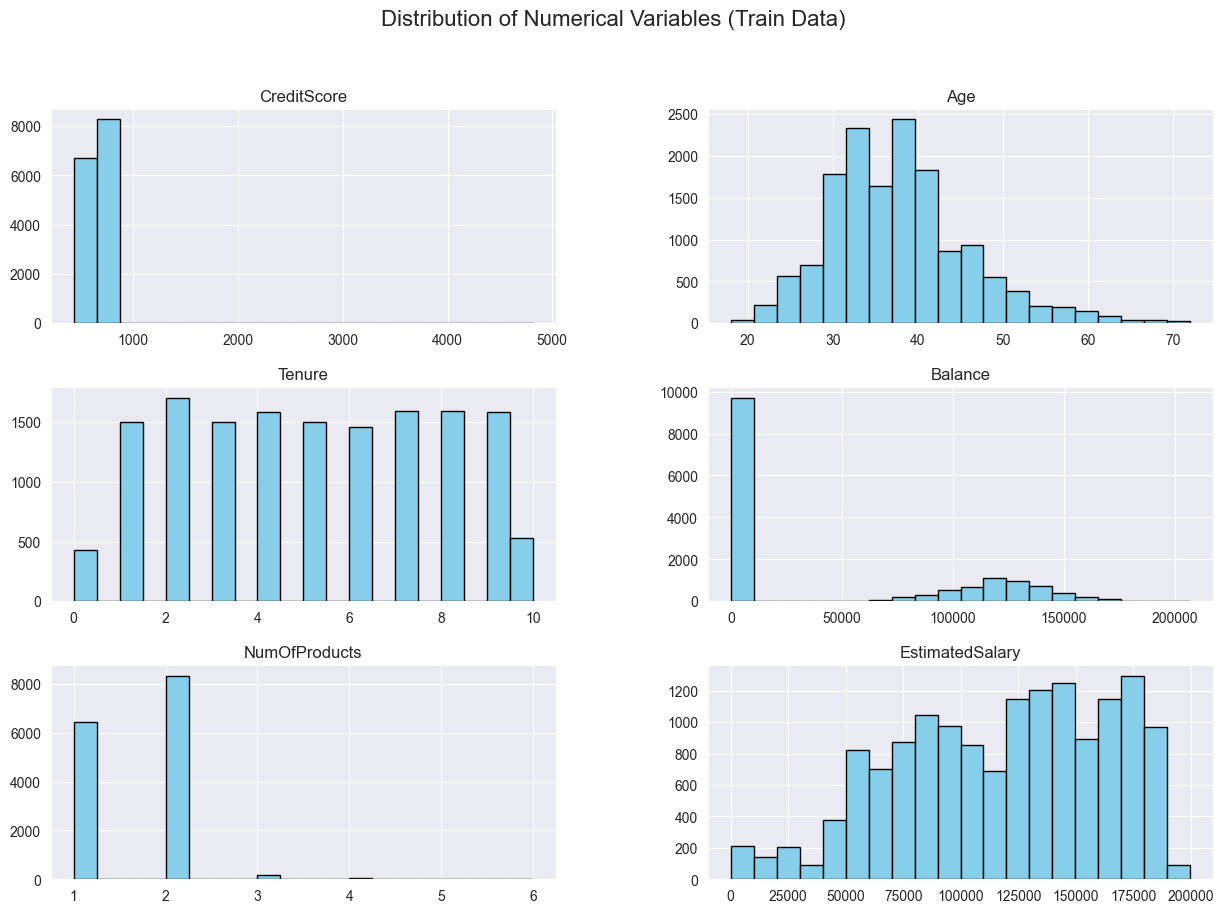

In [13]:
# Plot histograms of numerical variables
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
train_df[numerical_cols].hist(figsize=(15, 10), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Numerical Variables (Train Data)", fontsize=16)
plt.show()

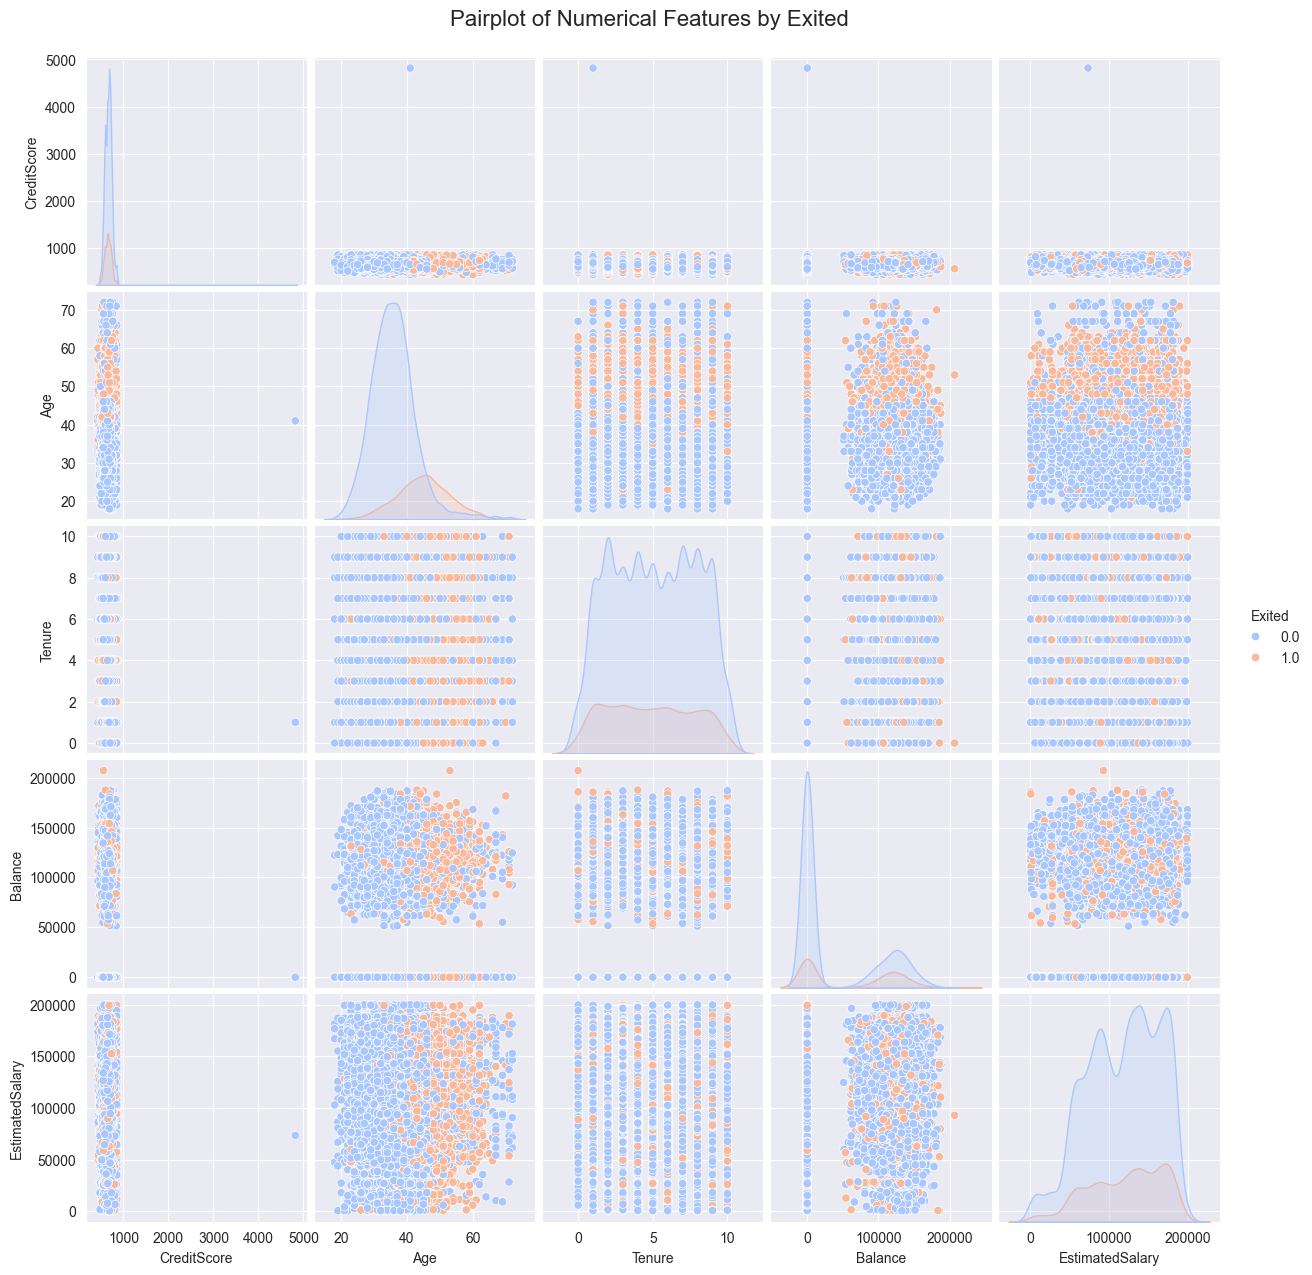

In [59]:
# Pairplot pour les principales variables
sns.pairplot(train_df, vars=['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary'], hue='Exited', palette='coolwarm')
plt.suptitle("Pairplot of Numerical Features by Exited", y=1.02, fontsize=16)
plt.show()

In [14]:



# Add AgeGroup (categorical: Young, Adult, Senior)
train_df['AgeGroup'] = pd.cut(
    train_df['Age'],
    bins=[-np.inf, 30, 50, np.inf],
    labels=['Young', 'Adult', 'Senior']
)
test_df['AgeGroup'] = pd.cut(
    test_df['Age'],
    bins=[-np.inf, 30, 50, np.inf],
    labels=['Young', 'Adult', 'Senior']
)

C:\Users\dumas\AppData\Local\Temp\ipykernel_5348\943236298.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x=col, ax=axes[i], palette='viridis')
C:\Users\dumas\AppData\Local\Temp\ipykernel_5348\943236298.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x=col, ax=axes[i], palette='viridis')
C:\Users\dumas\AppData\Local\Temp\ipykernel_5348\943236298.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x=col, ax=axes[i], palette='viridis')
C:\Users\dumas\AppData\Local\Temp\ipykernel_53

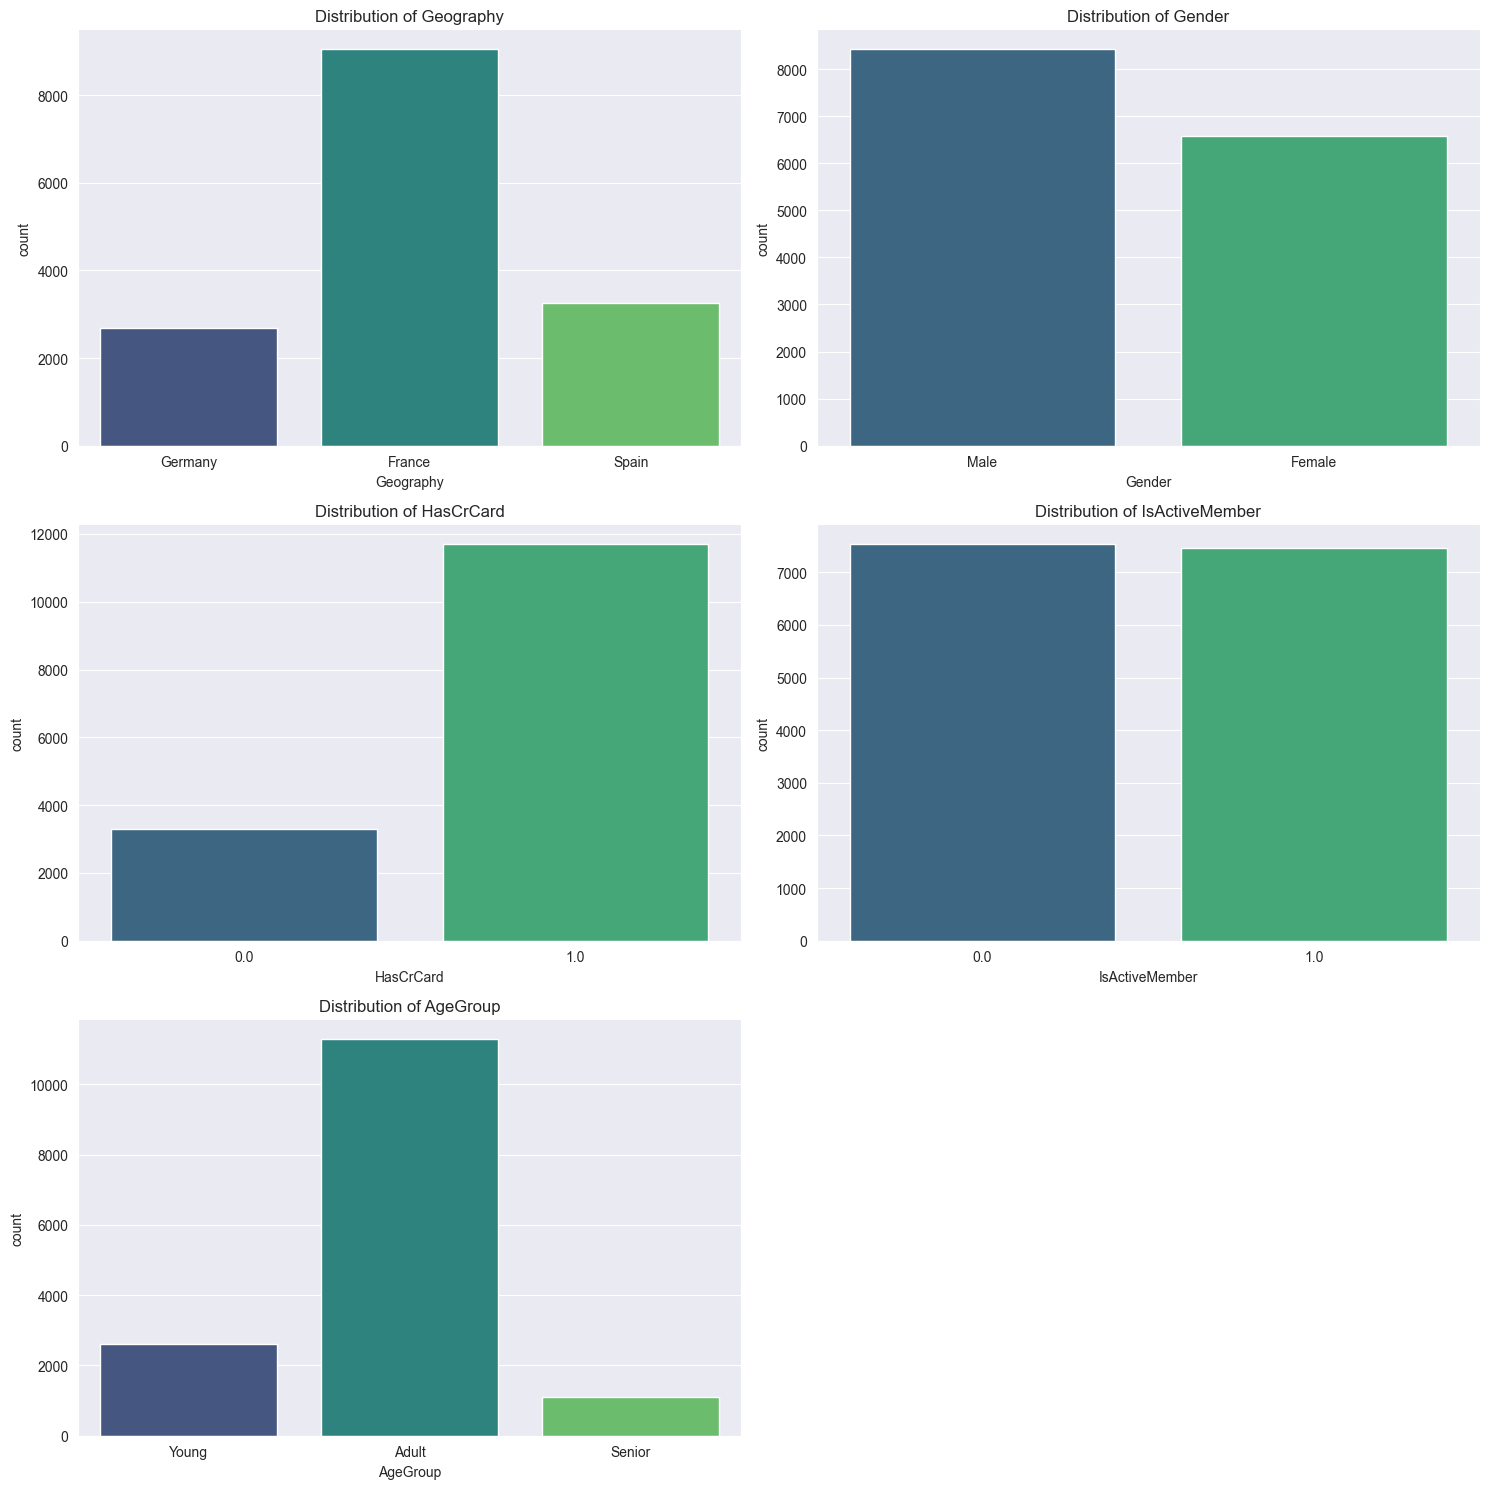

In [15]:
# Countplots for categorical variables
categorical_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'AgeGroup']

# Calculate the number of rows needed based on the number of columns
n_cols = 2  # Number of columns in the grid
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols  # Round up to the next whole number

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array to easily iterate
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=train_df, x=col, ax=axes[i], palette='viridis')
    axes[i].set_title(f"Distribution of {col}")

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

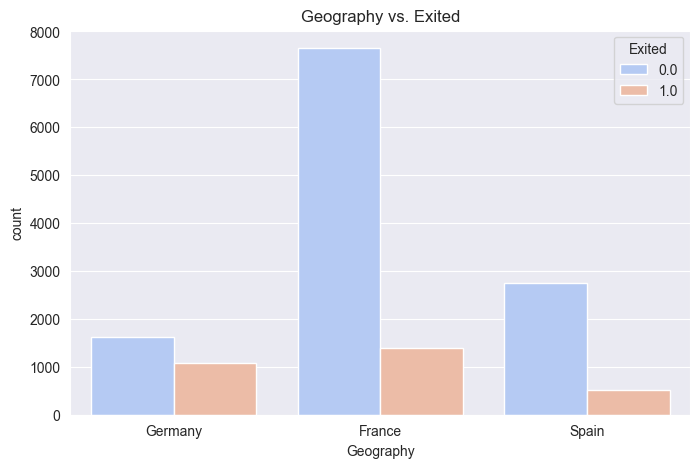

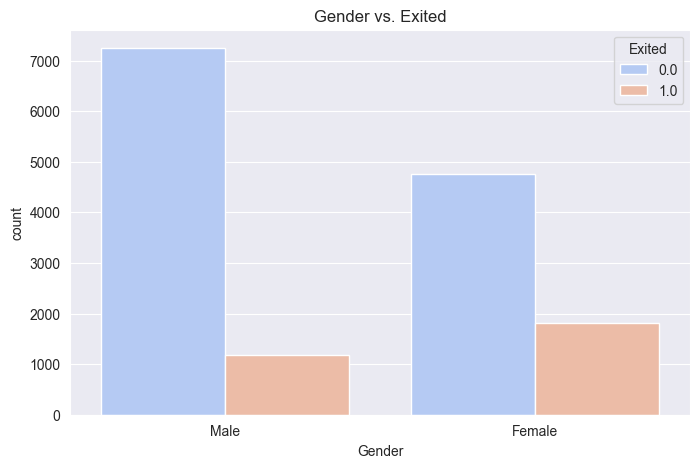

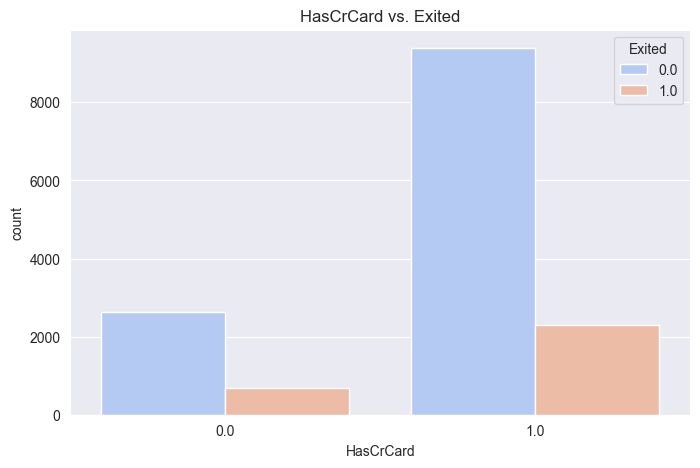

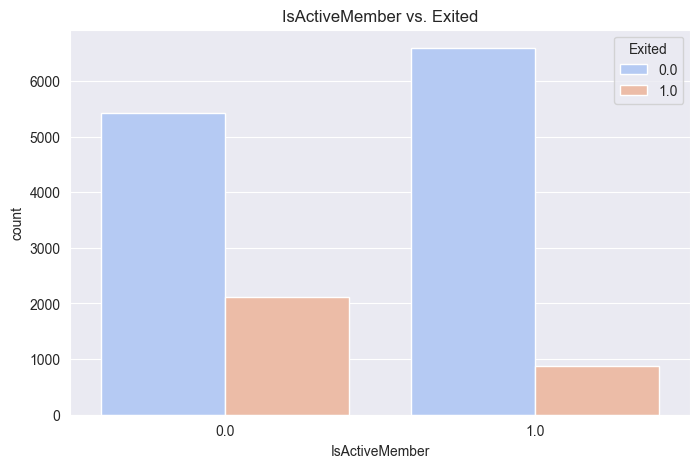

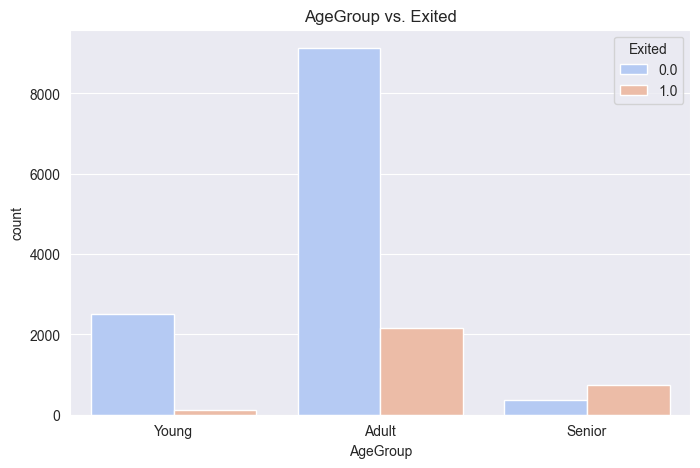

In [16]:
# Categorical features vs. Exited
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=train_df, x=col, hue='Exited', palette='coolwarm')
    plt.title(f"{col} vs. Exited")
    plt.show()

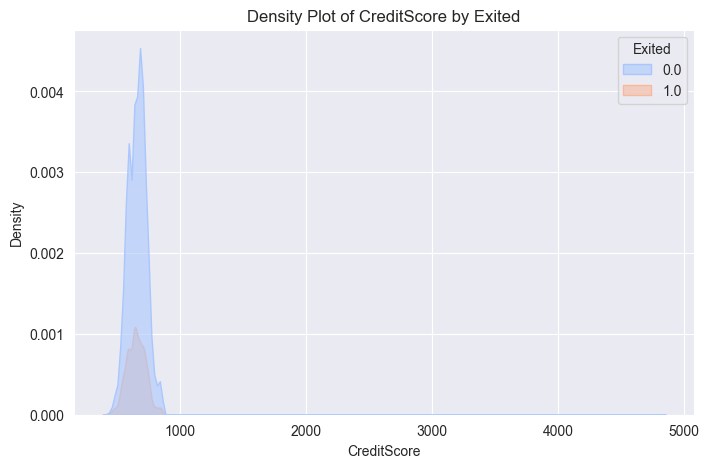

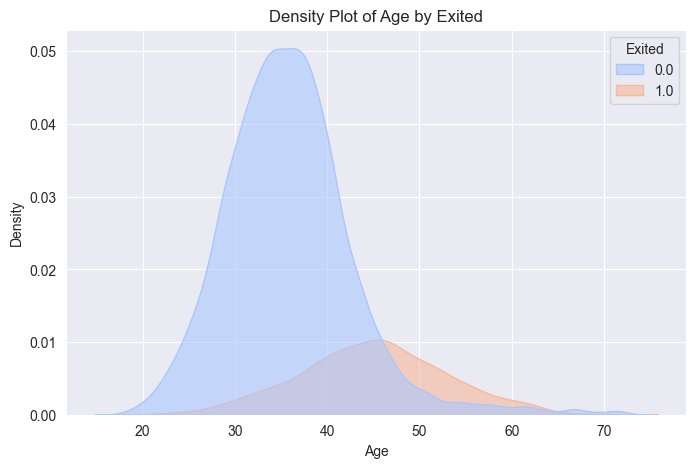

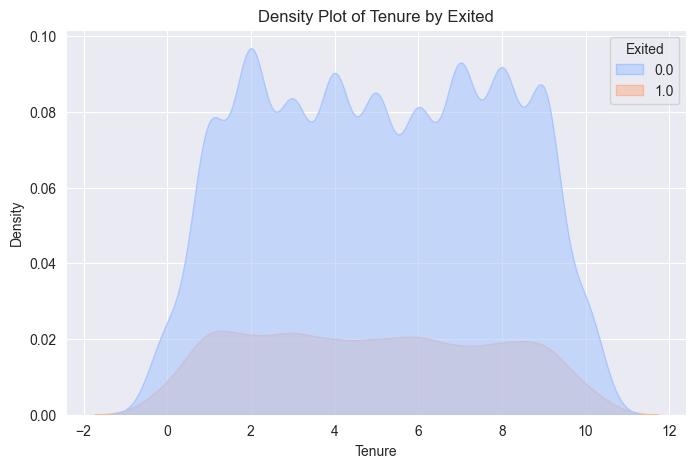

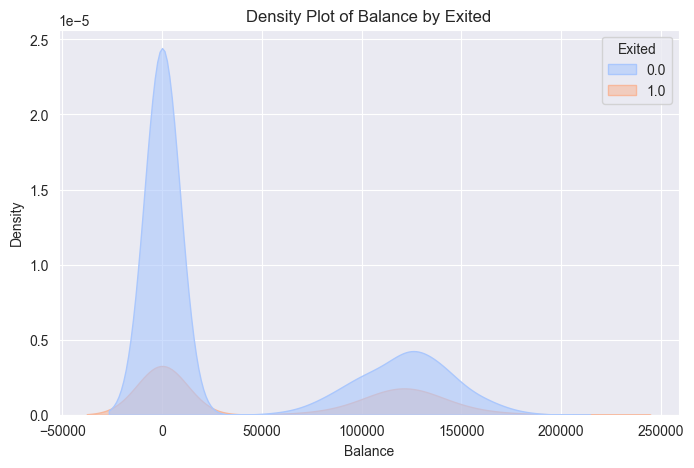

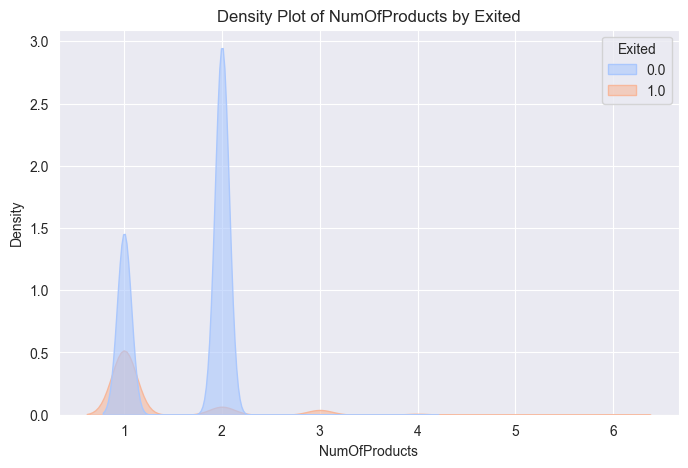

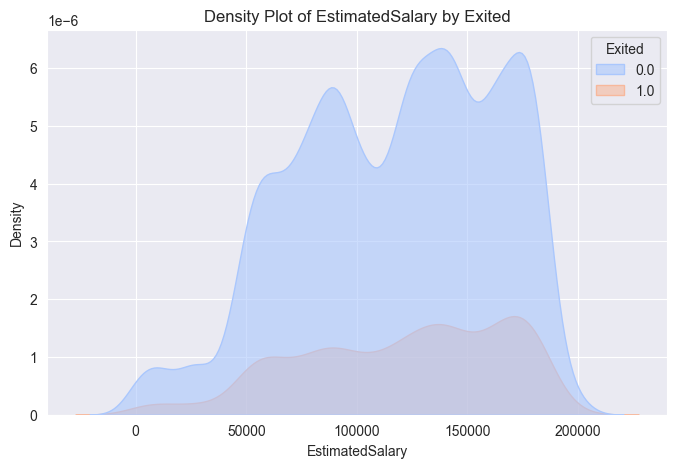

In [17]:
for col in numerical_cols:
    if col == 'Exited':  # Sauter la colonne Exited
        continue
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=train_df, x=col, hue='Exited', fill=True, palette='coolwarm', alpha=0.6)
    plt.title(f"Density Plot of {col} by Exited")
    plt.show()

In [18]:


train_df = pd.get_dummies(train_df, columns=['Geography', 'Gender','AgeGroup'])
test_df = pd.get_dummies(test_df, columns=['Geography', 'Gender','AgeGroup'])

# Exclude the outlier from the dataset
train_df = train_df[train_df['CreditScore'] <= 900]

# Nouvelle feature : client inactif avec solde élevé
train_df['Inactive_high_balance'] = ((train_df['Balance'] > 100000) & (train_df['IsActiveMember'] == 0)).astype(int)
test_df['Inactive_high_balance'] = ((test_df['Balance'] > 100000) & (test_df['IsActiveMember'] == 0)).astype(int)

train_df['EngagementScore'] = (
    train_df['Tenure'] * train_df['IsActiveMember'] * train_df['NumOfProducts']
)
test_df['EngagementScore'] = (
    test_df['Tenure'] * test_df['IsActiveMember'] * test_df['NumOfProducts']
)

# Création de nouvelles variables pour maximiser l'AUC
train_df['Age * Balance'] = train_df['Age'] * train_df['Balance']
test_df['Age * Balance'] = test_df['Age'] * test_df['Balance']

train_df['Balance / EstimatedSalary'] = train_df['Balance'] / train_df['EstimatedSalary']
test_df['Balance / EstimatedSalary'] = test_df['Balance'] / test_df['EstimatedSalary']

# Transformation logarithmique
train_df['Balance'] = np.log1p(train_df['Balance'])
test_df['Balance'] = np.log1p(test_df['Balance'])

# Renommer la colonne
train_df.rename(columns={'Balance': 'Log_Balance'}, inplace=True)
test_df.rename(columns={'Balance': 'Log_Balance'}, inplace=True)


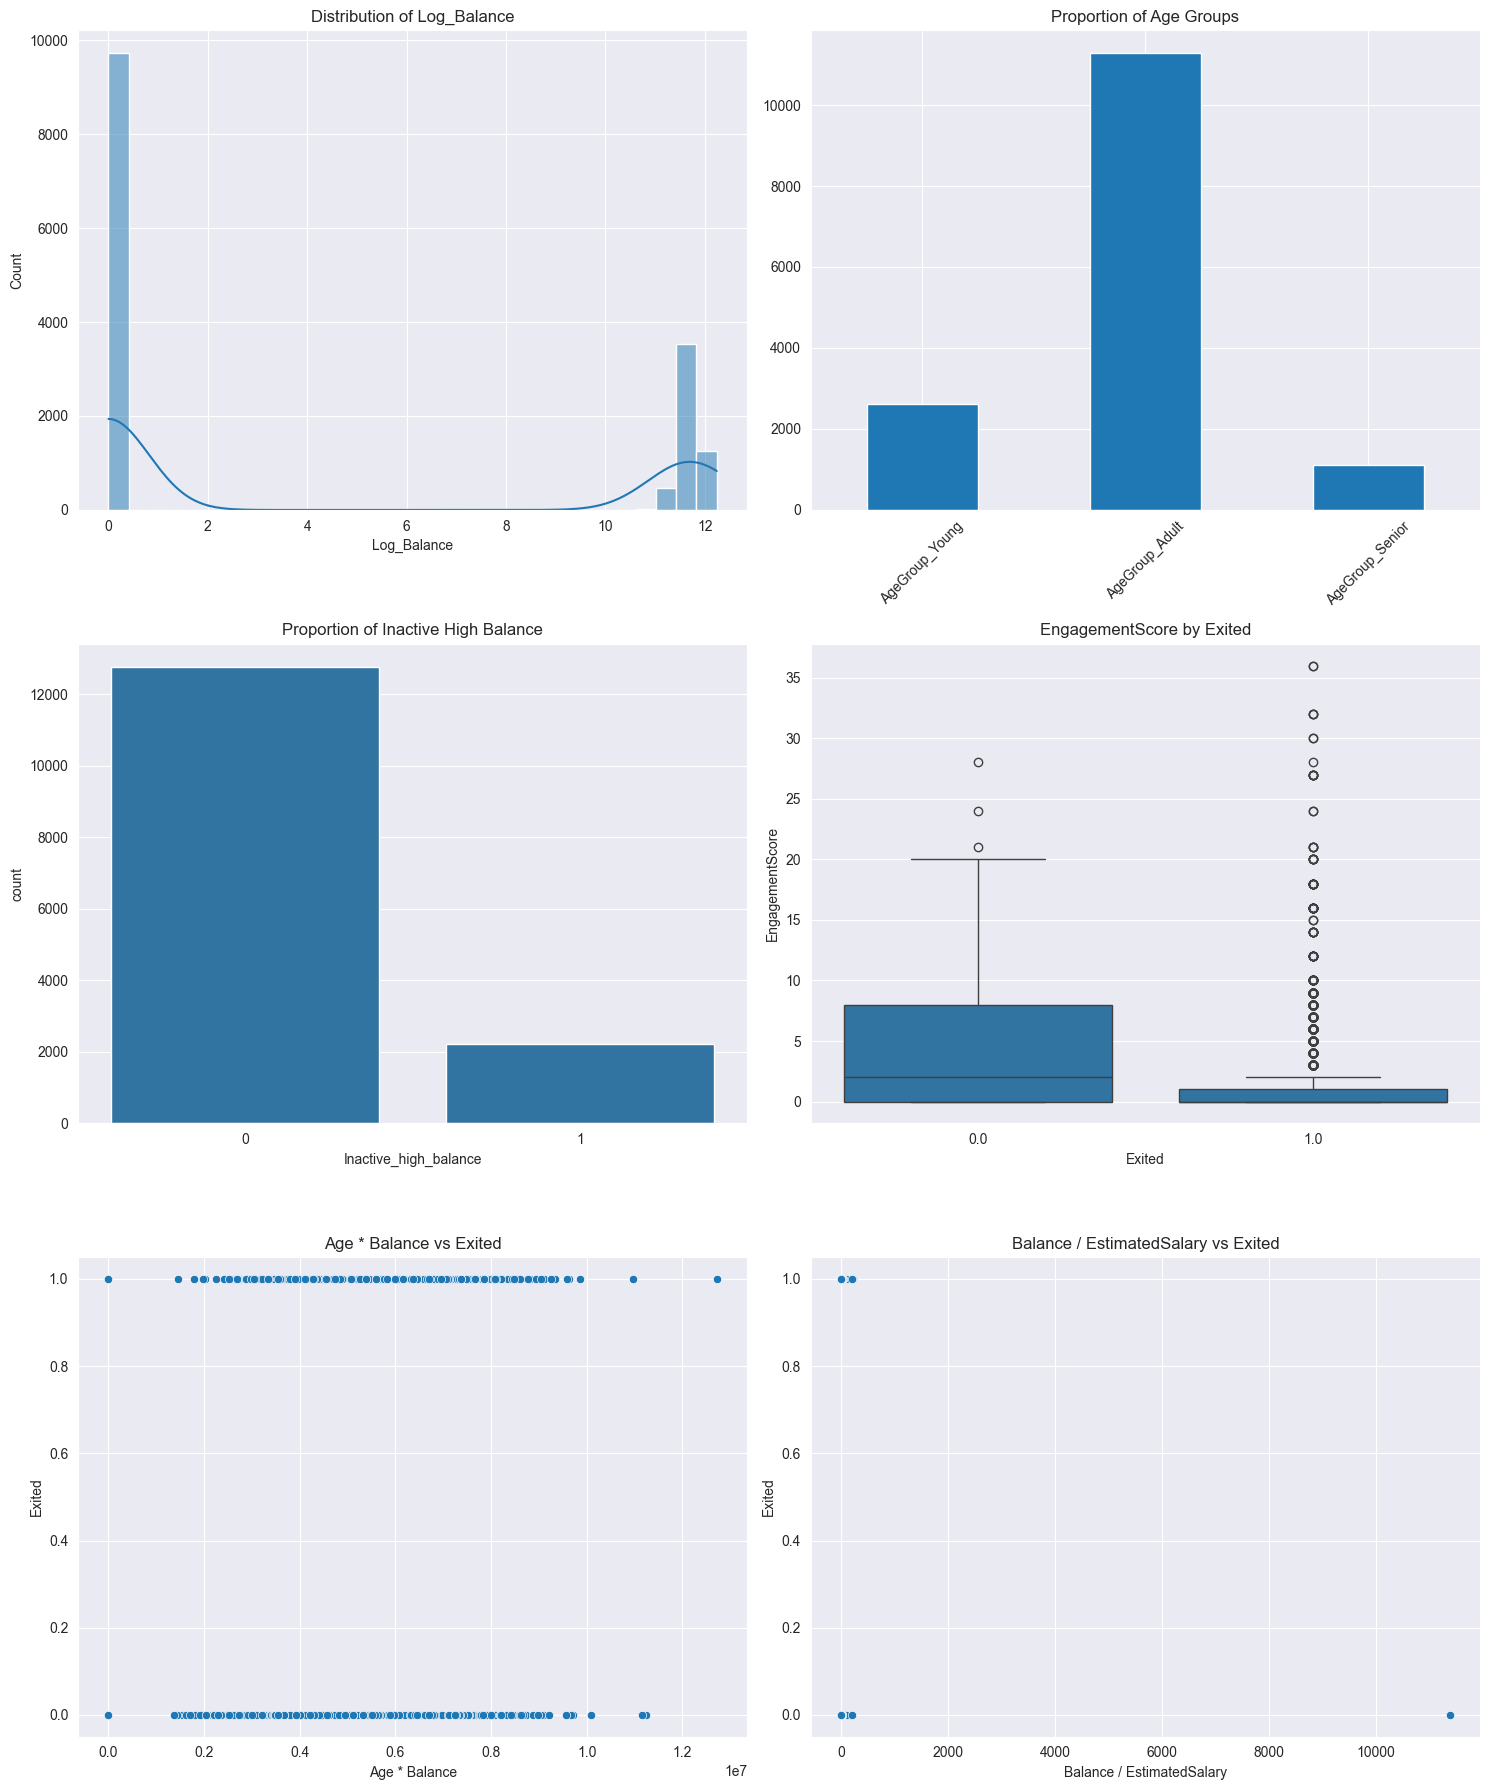

In [19]:
# Initialize subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# 1. Distribution of Log_Balance
sns.histplot(train_df['Log_Balance'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Log_Balance')

# 2. Proportion of Age Groups
age_group_counts = train_df.filter(like='AgeGroup').sum()
age_group_counts.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Proportion of Age Groups')
axes[0, 1].set_xticklabels(age_group_counts.index, rotation=45)

# 3. Proportion of Inactive_high_balance
sns.countplot(x='Inactive_high_balance', data=train_df, ax=axes[1, 0])
axes[1, 0].set_title('Proportion of Inactive High Balance')

# 4. EngagementScore vs Exited
sns.boxplot(x='Exited', y='EngagementScore', data=train_df, ax=axes[1, 1])
axes[1, 1].set_title('EngagementScore by Exited')

# 5. Age * Balance vs Exited
sns.scatterplot(x='Age * Balance', y='Exited', data=train_df, ax=axes[2, 0])
axes[2, 0].set_title('Age * Balance vs Exited')

# 6. Balance / EstimatedSalary vs Exited
sns.scatterplot(x='Balance / EstimatedSalary', y='Exited', data=train_df, ax=axes[2, 1])
axes[2, 1].set_title('Balance / EstimatedSalary vs Exited')

plt.tight_layout()
plt.show()

In [20]:
# Colonnes continues à scaler
continuous_cols = [
    'CreditScore',
    'Age * Balance','EngagementScore', 'Balance / EstimatedSalary'
]

# Initialisation du scaler
scaler = StandardScaler()
train_df[continuous_cols] = scaler.fit_transform(train_df[continuous_cols])
test_df[continuous_cols] = scaler.transform(test_df[continuous_cols])

# Features et cible
X = train_df.drop(columns=["Exited", "id"])
y = train_df["Exited"]
X_test = test_df.drop(columns=["id"])


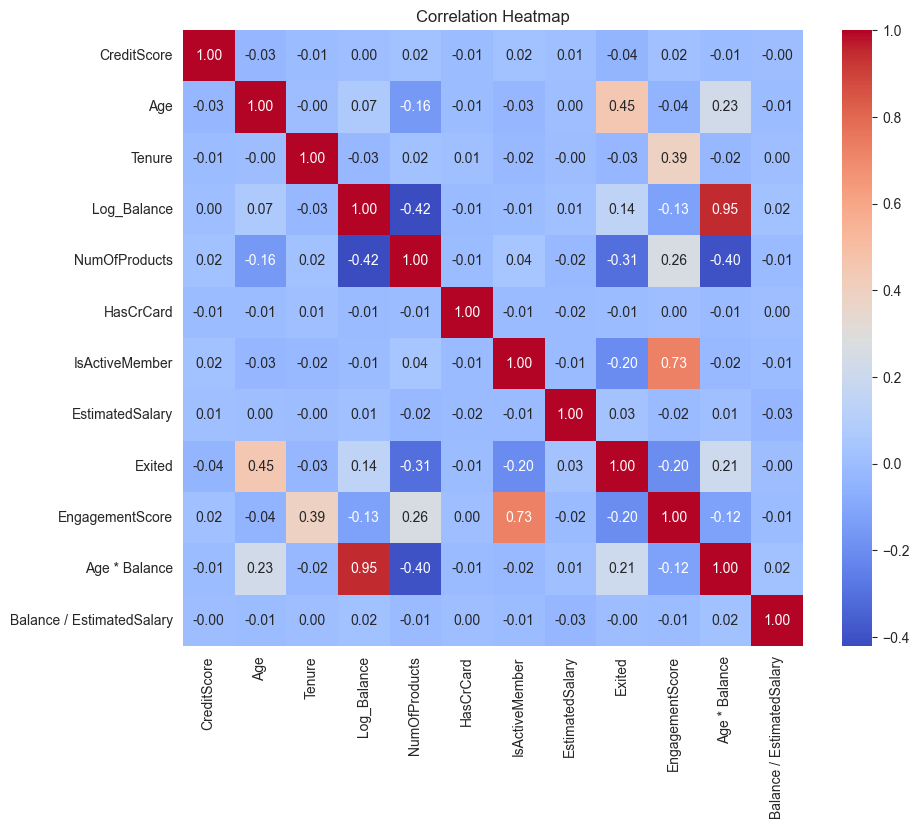

In [21]:

# Select only numerical columns for the correlation matrix
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop(['id', 'CustomerId'], errors='ignore')
# Compute the correlation matrix
correlation_matrix = train_df[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

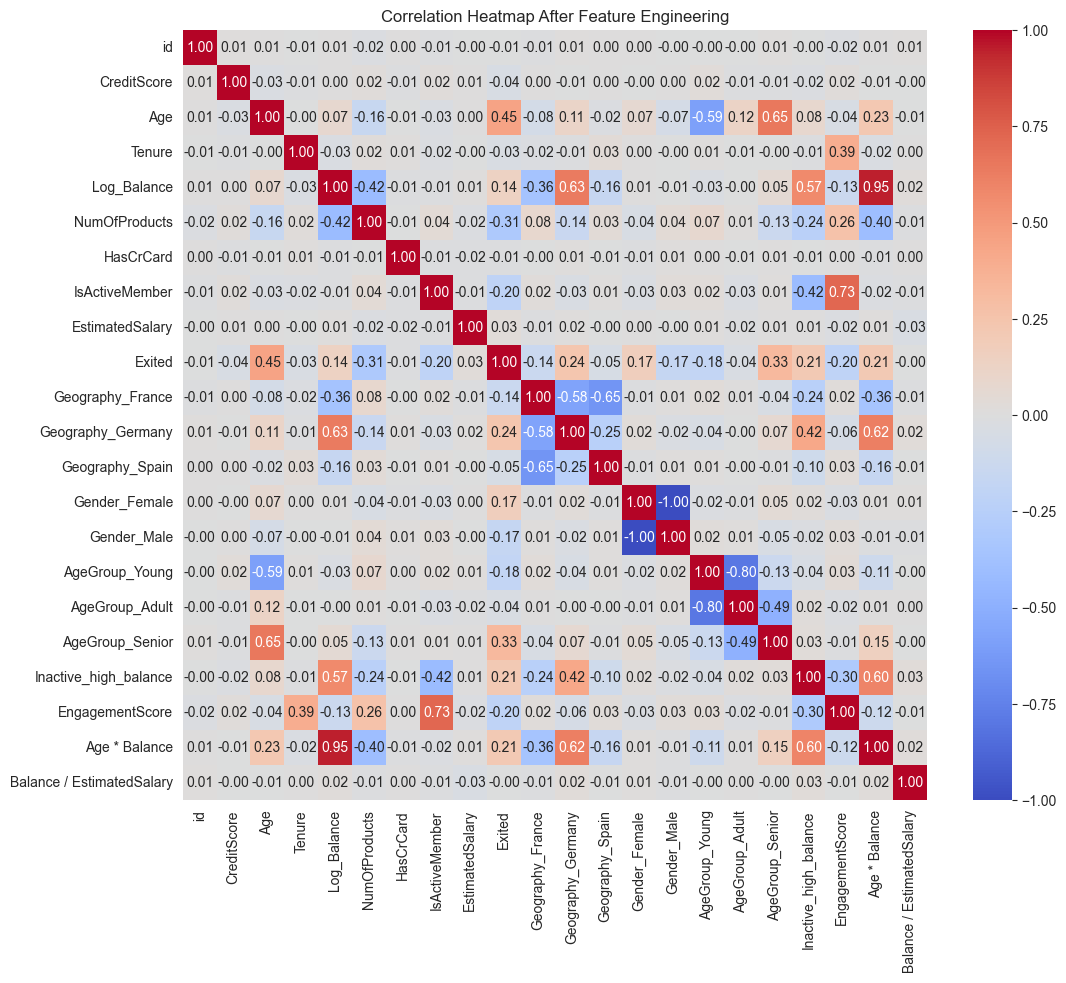

In [22]:
# Recompute correlation matrix
correlation_matrix = train_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap After Feature Engineering")
plt.show()

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Sélectionner uniquement les colonnes numériques et exclure la variable cible
X = train_df.select_dtypes(include=[np.number]).drop(columns=['Exited'])

# Calculer le VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Afficher les résultats
print("Variance Inflation Factor (VIF) pour chaque variable :")
print(vif_data.sort_values(by='VIF', ascending=False))

Variance Inflation Factor (VIF) pour chaque variable :
                      Feature        VIF
2                         Age  15.724844
4                 Log_Balance  13.745085
5               NumOfProducts   9.650040
11              Age * Balance   9.475486
8             EstimatedSalary   7.227370
7              IsActiveMember   6.095396
3                      Tenure   5.828135
6                   HasCrCard   4.365954
0                          id   3.883704
10            EngagementScore   3.263866
9       Inactive_high_balance   2.412495
1                 CreditScore   1.002444
12  Balance / EstimatedSalary   1.002091
